# Regularization

In practice, many networks we will face in network machine learning will *not* be simple networks. As we discussed in the preceding discussion, many of the techniques we discuss will be just fine to use with weighted networks. Unfortunately, these real world networks are often extremely noisy, and it is for this reason that analysis of one real world network might not generalize very well to a similar real world network. For this reason, we turn to *regularization*. On [wikipedia](#https://en.wikipedia.org/wiki/Regularization_(mathematics)), **regularization** is defined as, "the process of adding information in order to solve an ill-posed problem or to prevent overfitting." In network machine learning, what this usually will entail is modifying the network (or networks) themselves to allow better generalization of our statistical inference to new datasets. For each section, we'll pose an example, a simulation, and code for how to implement the desired regularization approach. But it is important to realize that you might use several of these techniques simultaneously in practice, or you might have reasons to use these techniques that go outside of our working examples.

## Regularization of the Nodes

### Degree trimming removes nodes with low degree

## Regularization of the Edges

### Symmetrizing the network gives us undirectedness

Let's say we have two brain networks from humans and aliens. In this case, we'll say there are six nodes, which are somehow shared across the two life forms. There is one node related to movement, one node related to hearing, one node related to higher-order thinking (like programming!), one node related taste, one node related to smell, and one node related to seeing. The edges $(i, j)$ here will represent the degree to which, if node $i$ is stimulated, node $j$ is stimulated as well. This network is weighted, and the edges take values between $-1$ (if node $i$ is stimulated, node $j$ is definitely *not* stimulated) and $1$ (if node $i$ is stimulated, node $j$ is definitely stimulated). A value of between the two would indicate that if node $i$ is stimulated, node $j$ might (or might not) be stimulated. Our goal is to measure the extent to which the two networks, *ignoring* asymmetries, are similar. Unfortunately, there is one big difference: the human network is *not* symmetric, but the alien network *is* symmetric! What this means is that in humans, node $i$ being stimulated leading to node $j$ does not necessarily mean that node $j$ being stimulated leads to node $i$ being stimulated. To accomplish this goal, we will *symmetrize* the human network. Let's take a look at two example networks. Notice that the human network is not symmetric:

In [169]:
from graspologic.simulations import sbm
from matplotlib import pyplot as plt
from graphbook_code import heatmap
from numpy.random import beta, gamma

wtargsh = [[dict(a=8, b=1), dict(a=2, b=10)],
          [dict(a=2, b=2), dict(a=8, b=1)]]

wtargsa = [[dict(shape=12.5, scale=1), dict(shape=9, scale=.5)],
          [dict(shape=9, scale=.5), dict(shape=12.5, scale=1)]]

# human brain network
Ah = sbm(n=[3,3], p=[[1,1], [1,1]], wt=beta, wtargs=wtargsh, loops=False, directed=True)

# alien brain network
Aa = sbm(n=[3,3], p=[[1, 1], [1, 1]], wt=gamma, wtargs=wtargsa, directed=False)

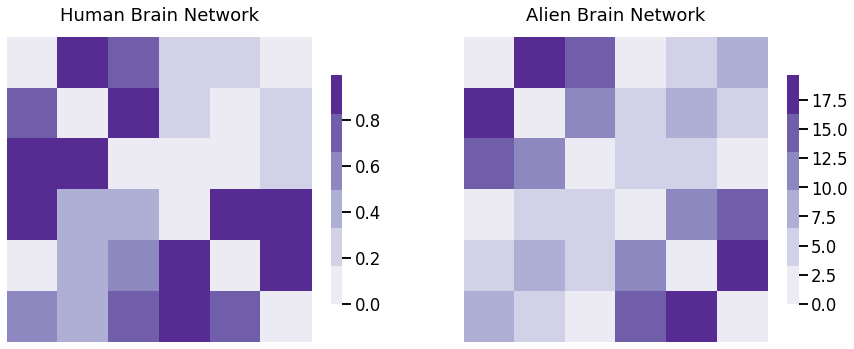

In [170]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(Ah, ax=axs[0], title="Human Brain Network")
heatmap(Aa, ax=axs[1], title="Alien Brain Network")
fig;

Remember that in a symmetric network, $a_{ij} = a_{ji}$, so in an *asymmetric* network, $a_{ij} \neq a_{ji}$. To symmetrize this asymmetric adjacency matrix, what we want is a *new* adjacency value, which we will call $w_{ij}$, which will be a function of $a_{ij}$ and $a_{ji}$. Then, we will construct a new adjacency matrix $A'$, where each entry $a_{ij}'$ *and* $a_{ji}'$ are set equal to $w_{ij}$.  The little apostraphe just signifies that this is a potentially different value than either $a_{ij}$ or $a_{ji}$. Note that by construction, $A'$ is in fact symmetric, becaues $a_{ij}' = a_{ji}'$ due to how we built $A'$. 

#### Ignoring a "triangle* of the adjacency matrix

The easiest way to symmetrize a network $A$ is to just ignore part of it entirely. In the adjacency matrix $A$, you will remember that we have an upper and a lower triangular part of the matrix:
\begin{align*}
    A &= \begin{bmatrix}
        a_{11} & \color{red}{a_{12}} & \color{red}{...} & \color{red}{a_{1n}} \\
        \color{blue}{a_{21}} & \ddots & \color{red}{\ddots} & \color{red}{\vdots} \\
        \color{blue}{\vdots} &\color{blue}{\ddots} &\ddots & \color{red}{a_{n-1, n}}\\
        \color{blue}{a_{n1}} & \color{blue}{...} & \color{blue}{a_{n,n-1}} & a_{nn}
    \end{bmatrix},
\end{align*}
The entries which are listed in <font color="red">red</font> are called the **upper right triangle of the adjacency matrix above the diagonal**. You will notice that for the entries $a_{ij}$ in the upper right triangle of the adjacency matrix, that $a_{ij}$ is such that $j$ is *always* greater than $i$. Similarly, the entries which are listed in <font color="blue">blue</font> are called the **lower left triangle of the adjacency matrix below the diagonal**. In the lower left triangle, $i$ is *always* greater than $j$. These are called *triangles* because of the shape they make when you look at them in matrix form: notice, for instance, that in the upper right triangle, we have a triangle with three corners of values: $a_{12}$, $a_{1n}$, and $a_{n-1, n}$.

So, how do we ignore a triangle all-together? Well, it's really quite simple! We will visually show how to ignore the lower left triangle of the adjacency matrix. We start by forming a triangle matrix, $\Delta$, as follows:
\begin{align*}
    \Delta &= \begin{bmatrix}
        0 & \color{red}{a_{12}} & \color{red}{...} & \color{red}{a_{1n}} \\
        \color{blue}{0} & \ddots & \color{red}{\ddots} & \color{red}{\vdots} \\
        \color{blue}{\vdots} &\color{blue}{\ddots} &\ddots & \color{red}{a_{n-1, n}}\\
        \color{blue}{0} & \color{blue}{...} & \color{blue}{0} & 0
    \end{bmatrix},
\end{align*}
Notice that this matrix *keeps* lal of the upper right triangle of the adjacency matrix above the diagonal the same as in the matrix $A$, but replaces the lower right triangle of the adjacency matrix below the diagonal and the diagonal with $0$s. Notice that the transpose of $\Delta$ is the matrix:
\begin{align*}
    \Delta^\top &= \begin{bmatrix}
        0 & \color{blue}{0} & \color{blue}{...} &\color{blue}{0}\\
        \color{red}{a_{12}}& \ddots & \color{blue}{\ddots} & \color{blue}{\vdots} \\
        \color{red}{\vdots}&\color{red}{\ddots} & \ddots & \color{blue}{0} \\
        \color{red}{a_{1n}}&\color{red}{...} &\color{red}{a_{n-1,n}} & 0
    \end{bmatrix}
\end{align*}
So when we add the two together, we get this:
\begin{align*}
    \Delta + \Delta^\top &= \begin{bmatrix}
        0 & \color{red}{a_{12}} & \color{red}{...} & \color{red}{a_{1n}} \\
        \color{red}{a_{12}} & \ddots & \color{red}{\ddots} & \color{red}{\vdots} \\
        \color{red}{\vdots}&\color{red}{\ddots} &\ddots & \color{red}{a_{n-1, n}}\\
        \color{red}{a_{1n}}&\color{red}{...} &\color{red}{a_{n-1,n}} & 0
    \end{bmatrix},
\end{align*}
We're almost there! We just need to add back the diagonal of $A$, which we will do using the matrix $diag(A)$ which has values $diag(A)_{ii} = a_{ii}$, and $diag(A)_{ij} = 0$ for any $i \neq j$:
\begin{align*}
    A' &= \Delta + \Delta^\top + diag(A) = \begin{bmatrix}
        a_{11} & \color{red}{a_{12}} & \color{red}{...} & \color{red}{a_{1n}} \\
        \color{red}{a_{12}} & \ddots & \color{red}{\ddots} & \color{red}{\vdots} \\
        \color{red}{\vdots}&\color{red}{\ddots} &\ddots & \color{red}{a_{n-1, n}}\\
        \color{red}{a_{1n}}&\color{red}{...} &\color{red}{a_{n-1,n}} & a_{nn}
    \end{bmatrix},
\end{align*}
Which leaves $A'$ to be a matrix consisting *only* of entries which were in the upper right triangle of $A$. $A'$ is obviously symmetric, because $a_{ij}' = a_{ji}'$ for all $i$ and $j$. Since the adjacency matrix is symmetric, the network $A'$ represents is therefore undirected. In graspologic, we can implement this as follows:

In [171]:
from graspologic.utils import symmetrize

# symmetrize with upper right triangle
Ah_upright_sym = symmetrize(Ah, method="triu")

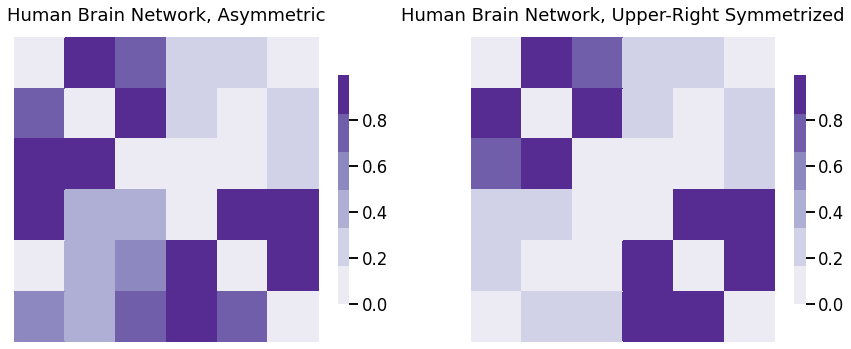

In [172]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(Ah, ax=axs[0], title="Human Brain Network, Asymmetric")
heatmap(Ah_upright_sym, ax=axs[1], title="Human Brain Network, Upper-Right Symmetrized")
fig;

Likewise, we can lower-left symmetrize as well:

In [173]:
# symmetrize with lower left triangle
Ah_lowleft_sym = symmetrize(Ah, method="tril")

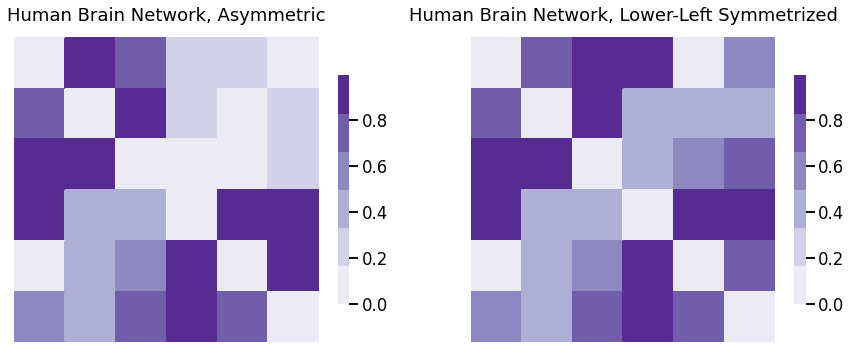

In [174]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(Ah, ax=axs[0], title="Human Brain Network, Asymmetric")
heatmap(Ah_lowleft_sym, ax=axs[1], title="Human Brain Network, Lower-Left Symmetrized")
fig;

#### Taking a function of the two values

There are many ways we can also take a function of $a_{ij}$ and $a_{ji}$ to end up with a symmetric matrix. One such is we can just average the two. That is, we can let the matrix $A'$ be the matrix with entries $a'_{ij} = \frac{a_{ij} + a_{ji}}{2}$ for all $i$ and $j$. In matrix form, this operation looks like this:

\begin{align*}
    A' &= \frac{1}{2} (A + A^\top) \\
    &= \frac{1}{2}\left(\begin{bmatrix}
        a_{11} & ... & a_{1n} \\
        \vdots & \ddots & \vdots \\
        a_{n1} & ... & a_{nn}
    \end{bmatrix} + \begin{bmatrix}
        a_{11} & ... & a_{n1} \\
        \vdots & \ddots & \vdots \\
        a_{1n} & ... & a_{nn}
    \end{bmatrix}\right)\\
    &= \begin{bmatrix}
        \frac{1}{2}(a_{11} + a_{11}) & ... & \frac{1}{2}(a_{1n} + a_{n1}) \\
        \vdots & \ddots & \vdots \\
        \frac{1}{2} (a_{n1} + a_{1n}) & ... & \frac{1}{2}(a_{nn} + a_{nn})
    \end{bmatrix} \\
    &= \begin{bmatrix}
        a_{11} & ... & \frac{1}{2}(a_{1n} + a_{n1}) \\
        \vdots & \ddots & \vdots \\
        \frac{1}{2} (a_{n1} + a_{1n}) & ... & a_{nn}
    \end{bmatrix}
\end{align*}
As we can see, for all of the entries, $a'_{ij} = \frac{1}{2} (a_{ij} + a_{ji})$, and also $a_{ji}' = \frac{1}{2}(a_{ji} + a_{ij})$. These quantities are the same, so $a_{ij}' = a_{ji}'$, and $A'$ is symmetric. As the adjacency matrix is symmetric, the network that $A'$ represents is undirected. We can implement this in graspologic as follows:

In [175]:
# symmetrize with averaging
Ah_avg_sym = symmetrize(Ah, method="avg")

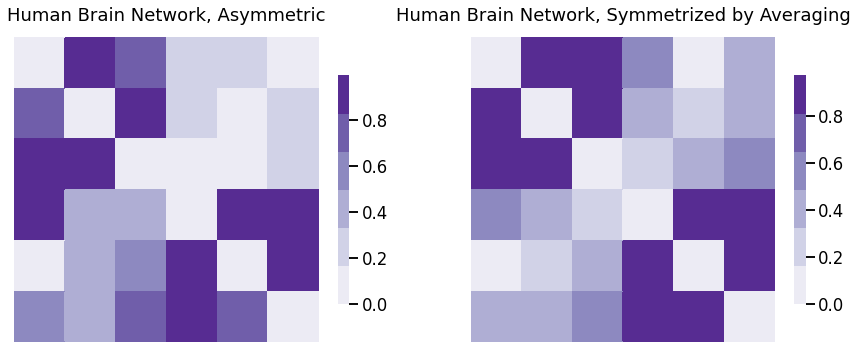

In [176]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(Ah, ax=axs[0], title="Human Brain Network, Asymmetric")
heatmap(Ah_avg_sym, ax=axs[1], title="Human Brain Network, Symmetrized by Averaging")
fig;

We will operate on the human brain newtork symmetrized by averaging going forward.

### Lowering edge bias

As you are probably aware, in all of machine learning, we are always concerned with the *bias/variance tradeoff*. The **bias/variance tradeoff** is an unfortunate side-effect that concerns how well a learning technique will generalize to new datasets. Whereas a low bias model might reasonably fit the nuances of our training data, it might in fact overfit the training data and model spurious noise, which raises the variance. Whereas aa lower variance model might be better suited to the situation when the data we expect to see is noisy, it might not as faithfully represent the underlying dynamics we think the network possesses. Here, we show severaal strategies to reduce the bias due to edge weight noise in network machine learning.

### Thresholding converts weighted networks to binary networks

The simplest way to reduce edge bias is the process of *thresholding*. Through thresholding, we choose a threshold value, $t$. Next, we simply set all of the entries of the adjacency matrix less than or equal to $t$ to zero, and the entries of the adjacency matrix above $t$ to one. 

Some of the most to choosing this threshold are:

1. Set the threshhold to be zero: set all non-zero weighted entries to one, and all zero-weight entries to zero. This is most commonly used when we see zero-inflated networks, or networks where the adjacency matrix takes values that are either zero or some quantity different from one, 
2. Set te threshold to be the mean: set all values below the mean edge-weight to zero, and all values above the mean edge-weight to one,
3. Pick a percentile: the most common appproach is to choose a particular percentile, and divide it by $100$ to obtain the **quantile**. Set the edge weights below this quantile to zero and above this quantile to one. This approach has the nice property that if we are performing inference on multiple networks whosse density exceeds the percentile we pick, it preserves the *network density* between them.

We will show how to use the percentile approach to binarization, with both our human and alien brains. We will threshold using the edge-weight in the $50^{th}$ percentile, which means that we will take the threshold to be the average of the two edge-weights in the middle and set all edges below this threshold to zero, and above this threshold to one. Note that how you perform the thresholding procedure might be dependent on properties of your network. Our example networks of humans and aliens were loopless, as you could see above. Remember as we learned in the preceding section, that if the network itself is loopless, the diagonal entries simply *do not exist*; $0$ is simply a commonly used placeholder. For this reason, when we compute the mean edge-weight or percentiles of edge-weights, we need to exclude the diagonal. We begin by using this procedure on the human brain:

In [177]:
from numpy import quantile, copy, where, eye

p = 50  # the percentile we want

# the entries of the adjacency matrix that are not on the diagonal
non_diag_idx = where(~eye(Ah_avg_sym.shape[0], dtype=bool))
# use the quantile function to obtain the threshold
t = quantile(Ah_avg_sym[non_diag_idx], q=p/100)  # quantile = percentile / 100
Ah_thresh = copy(Ah_avg_sym)  # copy the network over

# threshold using t
Ah_thresh[Ah_thresh <= t] = 0
Ah_thresh[Ah_thresh > t] = 1

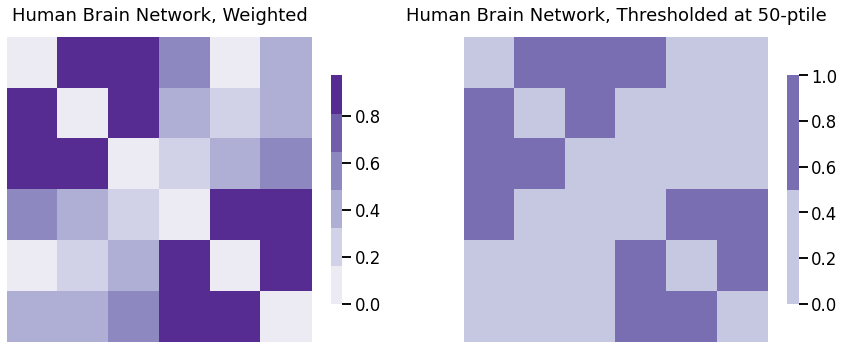

In [178]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(Ah_avg_sym, ax=axs[0], title="Human Brain Network, Weighted")
heatmap(Ah_thresh, ax=axs[1], title="Human Brain Network, Thresholded at 50-ptile")
fig;

Likewise, we can do the same thing for the alien brain:

In [179]:
from numpy import quantile, copy

p = 50  # the percentile we want

# use the quantile function to obtain the threshold
t = quantile(Aa[non_diag_idx], q=p/100)  # quantile = percentile / 100
Aa_thresh = copy(Aa)  # copy the network over

# threshold using t
Aa_thresh[Aa_thresh <= t] = 0
Aa_thresh[Aa_thresh > t] = 1

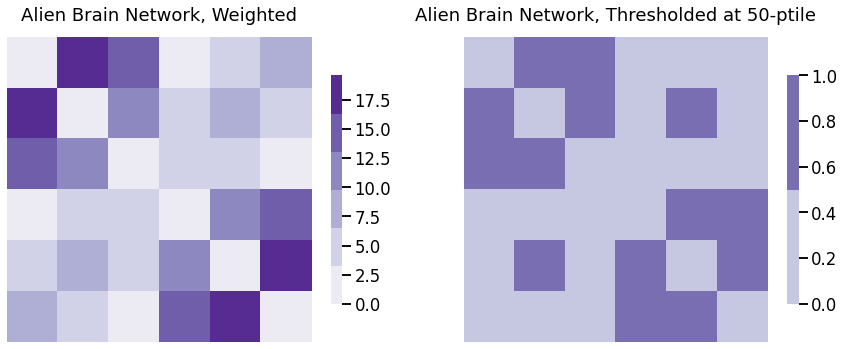

In [180]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(Aa, ax=axs[0], title="Alien Brain Network, Weighted")
heatmap(Aa_thresh, ax=axs[1], title="Alien Brain Network, Thresholded at 50-ptile")
fig;

Since the human and alien brain networks are now undirected, unweighted, and loopless, we have turned them into simple networks. Remember that the network density for a simple network was defined as:

\begin{align*}
    density(A) &= \frac{2\sum_{j > i}a_{ij}}{n(n - 1)}.
\end{align*}

Since we have thresholded at the $50^{th}$ percentile for both the human and alien networks, then note that *exactly* $50$ percent of the possible edges will exist, and $50$ percent of the possible edges will not exist. Remembering that the number of possible edges was $\frac{1}{2}n(n - 1)$ for an undirected network, this means that $\sum_{j > i}a_{ij}$ must be half of $\frac{1}{2}n(n - 1)$, or $\frac{1}{4}n(n - 1)$. Therefore:
\begin{align*}
    density(A^{(h)}) = density(A^{(a)}) &= \frac{2\sum_{j > i}a_{ij}}{n(n - 1)}, \\
    &= \frac{2\cdot \frac{1}{4}n(n - 1)}{n(n - 1)},\;\;\;\sum_{j > i}a_{ij} = \frac{1}{4}n(n - 1) \\
    &= 0.5.
\end{align*}
So if we threshold two networks at the same percentile, we end up with networks of equal density, and that density is equal to the fraction which is equivalent to the percentile we chose.

Note that a common pitfall you might run into with thresholding (and other sparsification approaches) that rely on percentiles occurs when a weighted network can only take non-negative edge-weights. This corresponds to a network with an adjacency matrix $A$ where every $a_{ij}$ is greater than or equal to $0$. In this case, one must be careful to choose a threshold which is not zero. Let's consider a network were $60\%$ of the entries are zeros, and $40\%$ of the entries take a random value between $5$ and $10$:

In [181]:
from graspologic.simulations import er_nm
from numpy.random import uniform

# 10 nodes
n = 10
# total number of edges is 40% of the number of possible edges
# 1/2 * n * (n-1)
m = int(0.4*0.5*n*(n-1))
A = er_nm(n, m, wt=uniform, wtargs=dict(low=5, high=10))

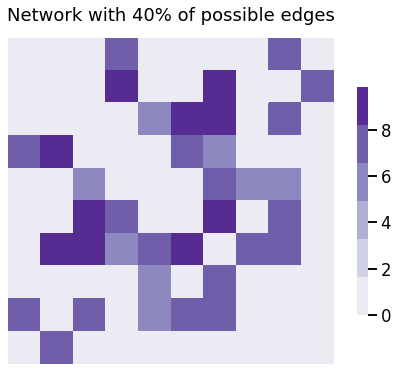

In [182]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))

heatmap(A, ax=axs, title="Network with 40% of possible edges");

If we threshold at the $50^{th}$ percentile, since $60$ percent of the edges do not exist, then the $50^{th}$ percentile is still just zero:

In [183]:
# use the quantile function to obtain the threshold
t = quantile(A[non_diag_idx], q=p/100)  # quantile = percentile / 100
A_thresh = copy(A)  # copy the network over

# threshold using t
A_thresh[A_thresh <= t] = 0
A_thresh[A_thresh > t] = 1
print("Threshold for 50th percentile: {:d}".format(int(t)))

Threshold for 50th percentile: 0


And we don't actually end up with a network having a density of $0.5$, but rather, the same as the fraction of non-zero edges in the original network (which was $40\%$, or $0.4$):

In [184]:
from numpy import triu
from graspologic.utils import is_unweighted, is_loopless, is_symmetric

def simple_network_dens(X):
    # make sure the network is simple
    if (not is_unweighted(X)) or (not is_loopless(X)) or (not is_symmetric(X)):
        raise TypeError("Network is not simple!")
    # count the non-zero entries in the upper-right triangle
    # for a simple network X
    nnz = triu(X, k=1).sum()
    # number of nodes
    n = X.shape[0]
    # number of possible edges is 1/2 * n * (n-1)
    poss_edges = 0.5*n*(n-1)
    return nnz/poss_edges

dens = simple_network_dens(A_thresh)

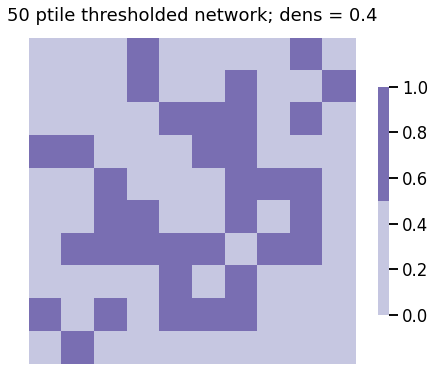

In [185]:
fig, axs = plt.subplots(1,1, figsize=(8, 6))

heatmap(A_thresh, ax=axs, title="50 ptile thresholded network; dens = {:.1f}".format(dens));

So the take-home message is that we need to be careful that if we want to conclude that two percentile-thresholded networks have the same network density (equal to the percentile we thresholded at) it is critical that we have enough non-zero entries to threshold with across both (or all) of the networks.

### Sparsification removes potentially spurious low-weight edges

The next simplest edge-weight regularization technique is called *sparsificiation*. Remember that our alien brain looked like this:

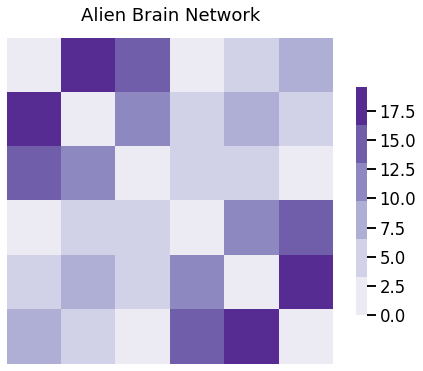

In [186]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))

heatmap(Aa, ax=ax, title="Alien Brain Network");

Notice that for a *lot* of the off-diagonal entries, many of the values are really tiny compared to the maximum value in the network which is almost $40$. What if the way we measured these edges was very sensitive to high values, but had trouble discerning whether a value was actually zero, or was just really small?

For this particular situation, we turn to *sparsification*. Through sparsification, we proceed very similar to thresholding like we did above. Remember that we chose a threshold, $t$, and first set all adjacency values less than or equal to $t$ to zero. Now, we're done! We simply skip the step of setting values greater than $t$ to one. Let's try an example where we take the alien network, and sparsify the network using the $20^{th}$ percentile. Note that this will lead to the smallest $20$ percent of edges to take the value of zero, and the largest $80$ percent of edges will keep their original edge-weights:

In [187]:
p = 20  # the percentile to sparsify with

# use the quantile function to obtain the threshold
t = quantile(Aa[non_diag_idx], q=p/100)  # quantile = percentile / 100
Aa_sparse = copy(Aa)  # copy the network over

# sparsify using t
Aa_sparse[Aa_sparse <= t] = 0

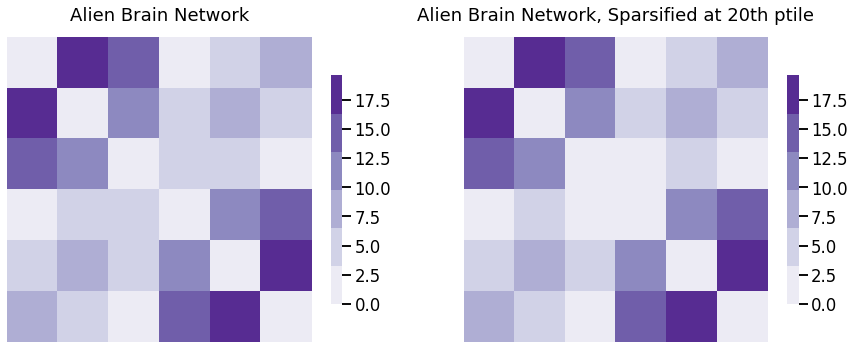

In [188]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(Aa, ax=axs[0], title="Alien Brain Network")
heatmap(Aa_sparse, ax=axs[1], title="Alien Brain Network, Sparsified at 20th ptile");

Notice that many of the small entries in the off-diagonal areas now have a value of zero. Again, we have the same pitfalls for sparsification as we did with thresholding, where if the network takes only non-negative edge weights and the percentile we choose corresponds to a threshold of zero, we might not actually end up changing anything.

### Diagonal augmentation

https://github.com/microsoft/graspologic/blob/f9c4353488e29d367dec62fdb4729e6a7344fd89/graspologic/embed/ase.py#L58

### Edge-weight normalization

With weighted networks, it is often the case that we might want to reshape the distributions of edge-weights in our networks to highlight particular properties. Notice that the edge-weights for our human networks take values between $0$ and $1$, but for our alien network take values between $0$ and almost $40$. How can we possibly compare between these two networks when the edge-weights take such different ranges of values? We turn to standardization, which allows us to place values from different networks on the same scale. 

#### $z$-scoring standardizes edge weights using the normal distribution

The first approach to edge-weight standardization is known commonly as $z$-scoring. Suppose that $A$ is the adjacency matrix, with entries $a_{ij}$. With a $z$-score, we will rescale the weights of the adjacency matrix, such that the new edge-weights (called $z$-scores) are approximately normally distributed. The reason this can be useful is that the normal distribution is pretty ubiquitous across many branches of science, and therefore, a $z$-score is relatively easy to communicate with other scientists. Further, many things that exist in nature can be well-approximated by a normal distribution, so it seems like a reasonable place to start to use a $z$-score for edge-weights, too! The $z$-score is defined as follows. We will construct the $z$-scored adjacency matrix $Z$, whose entries $z_{ij}$ are the corresponding $z$-scores of the adjacency matrix's entries $a_{ij}$. For a weighted, loopless network, we use an estimate of the *mean*, $\hat \mu$, and the *unbiased* estimate of the *variance*, $\hat \sigma^2$), which can be computed as follows:
\begin{align*}
    \hat\mu &= \frac{1}{n}\sum_{i \neq j}a_{ij},\\
    \hat\sigma^2 &= \frac{1}{n - 1}\sum_{i \neq j} (a_{ij} - \hat\mu)^2.
\end{align*}
The $z$-score for the $(i,j)$ entry is simply the quantity:
\begin{align*}
    z_{ij} &= \frac{a_{ij} - \hat\mu}{\hat\sigma}
\end{align*}
Since our network is loopless, notice that these sums are for all *non-diagonal* entries where $i \neq j$. If the network were not loopless, we would include diagonal entries in the calculation, and instead would sum over all possible combinations of $i$ and $j$. the interpretation of the $z$-score $z_{ij}$ is the *number of stadard deviations* that the entry $a_{ij}$ is from the mean, $\hat \mu$.

We will demonstrate on the network where $40\%$ of the entries took a value between $5$ and $10$, and the other $60\%$ took a value of zero. We can implement $z$-scoring as follows:

In [216]:
from scipy.stats import zscore
from numpy import zeros

def z_score_loopless(X):
    if not is_loopless(X):
        raise TypeError("The network has loops!")
    # the entries of the adjacency matrix that are not on the diagonal
    non_diag_idx = where(~eye(X.shape[0], dtype=bool))
    Z = zeros(X.shape)
    Z[non_diag_idx] = zscore(X[non_diag_idx])
    return Z

ZA = z_score_loopless(A)

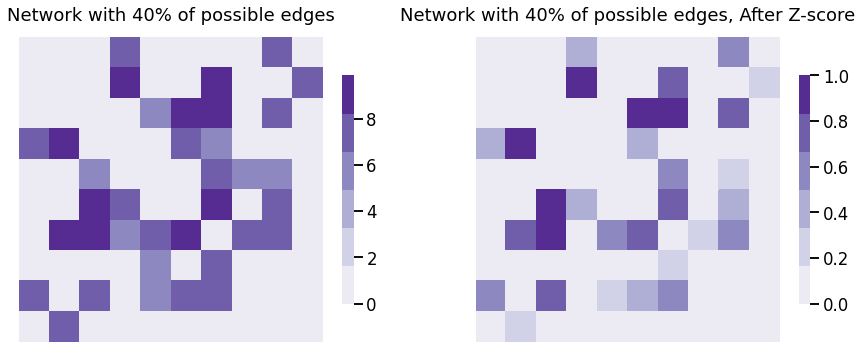

In [217]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(A, ax=axs[0], title="Network with 40% of possible edges")
heatmap(RA, ax=axs[1], title="Network with 40% of possible edges, After Z-score", vmin=0, vmax=1);

Next, we will look at the edge-weight histogram for the alien brain network before and after $z$-scoring. An edge-weight histogram is a histogram which indicates the number of edges with weights falling in between a pair of values. Remember that the network is loopless, so again we exclude the diagonal entries:

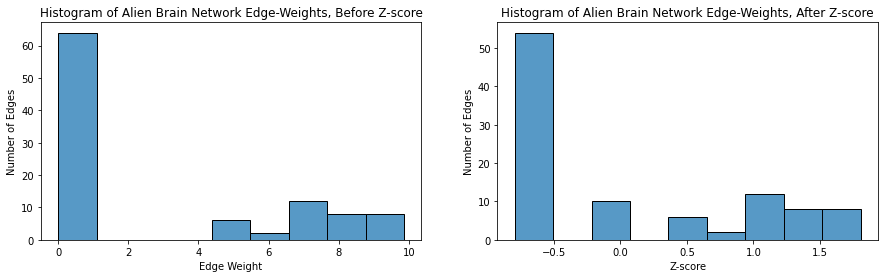

In [219]:
from seaborn import histplot

non_diag_idx = where(~eye(Aa.shape[0], dtype=bool))
fig, axs = plt.subplots(1,2, figsize=(15, 4))
ax = histplot(A.flatten(), ax=axs[0], bins=9)
ax.set_xlabel("Edge Weight");
ax.set_ylabel("Number of Edges");
ax.set_title("Network with 40% of possible edges, Before Z-score");
ax = histplot(ZA.flatten(), ax=axs[1], bins=9)
ax.set_xlabel("Z-score");
ax.set_ylabel("Number of Edges");
ax.set_title("Network with 40% of possible edges, After Z-score");

The theory for when, and why, to use $z$-scoring for network machine learning tends to go something like this: many things tend to be normally distributed with the same mean and variance, so perhaps that is a reasonable expectation for our network, too. Unfortunately, we find this often to *not* be the case. In fact, we often find that the specific distribution of edge weights itself often might be lamost infeasible to identify in a population of networks, and therefore *almost* irrelevant all-together. To this end, we turn to instead *ranking* the edges.

#### Ranking edges preserves ordinal relationships

The idea behind ranking is as follows. We don't really know much useful information as to how the distribution of edge weights varies between a given pair of networks. For this reason, we want to virtually eliminate the impact of that distribution *almost* entirely. However, we know that if one edge-weight is larger than another edge-weight, that we do in fact trust that relationship. What this means is that we want something which preserves *ordinal* relationships in our edge-weights, but ignores other properties of the edge-weights. An ordinal relationship just means that we have a natural ordering to the edge-weights. This means that we can identify a largest edge-weight, a smallest edge-weight, and every position in between. When we want to preserve ordinal relationships in our network, we do something called *passing the non-zero edge-weights to ranks*. We will often use the abbreviation `ptr` to define this function because it is so useful for weighted networks. We pass non-zero edge-weights to ranks as follows:

1. Identify all of the non-zero entries of the adjacency matrix $A$.
2. Count the number of non-zero entries of the adjacency matrix $A$, $n_{nz}$.
3. Rank all of the non-zero edges in the adjacency matrix $A$, where for a non-zero entry $a_{ij}$, $rank(a_{ij}) = 1$ if $a_{ij}$ is the smallest non-zero edge-weight, and $rank(a_{ij}) = n_{nz}$ if $a_{ij}$ is the largest edge-weight. Ties are settled by using the average rank of the two entries.
3. Report the weight of each non-zero entry $(i,j)$ as $r_{ij} = \frac{rank(a_{ij})}{n_{nz} + 1}$, and for eachh zero entry as $r_{ij} = 0$.

Below, we pass-to-ranks for the network with $40\%$ of the possible edges taking a value between $5$ and $10$, and the other $60\%$ taking a value of $0$ using `graspologic`:

In [209]:
from graspologic.utils import pass_to_ranks

RA = pass_to_ranks(A)

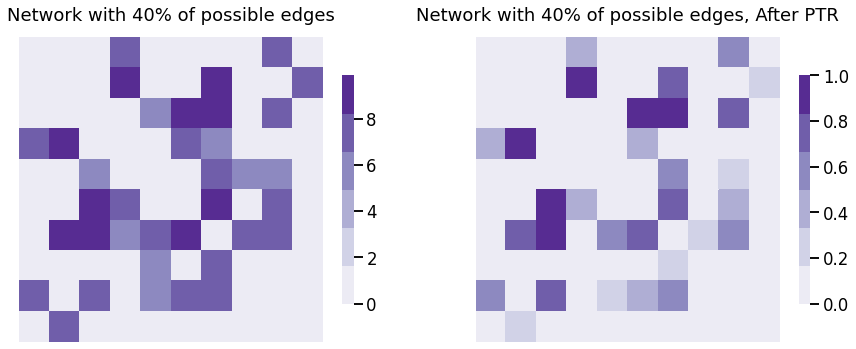

In [211]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(A, ax=axs[0], title="Network with 40% of possible edges")
heatmap(RA, ax=axs[1], title="Network with 40% of possible edges, After PTR", vmin=0, vmax=1);

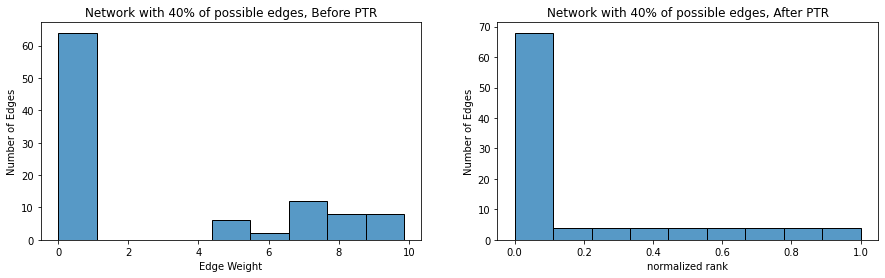

In [221]:
fig, axs = plt.subplots(1,2, figsize=(15, 4))
ax = histplot(A.flatten(), ax=axs[0], bins=9)
ax.set_xlabel("Edge Weight");
ax.set_ylabel("Number of Edges");
ax.set_title("Network with 40% of possible edges, Before PTR");
ax = histplot(RA.flatten(), ax=axs[1], binrange=[0, 1], bins=9)
ax.set_xlabel("normalized rank");
ax.set_ylabel("Number of Edges");
ax.set_title("Network with 40% of possible edges, After PTR");

The edge-weights for the adjacency matrix $R$ after `ptr` has the interpretataion that each entry $r_{ij}$ is the *quantile* of that entry amongst the other non-zero entries. This is unique in that it is completely *distribution-free*, which means that we don't need to assume anything about the distribution of the edge-weights to have a reasonably interpretable quantity. On the other hand, the $z$-score had the interpretation of the number of standard deviations from the mean, which is only a sensible quantity to compare if we assume the population of edge-weights are normally distributed.

Another useful quantity related to pass-to-ranks is known as the zero-boosted pass-to-ranks. Zero-boosted pass-to-ranks is conducted as follows:

1. Identify all of the non-zero entries of the adjacency matrix $A$.
2. Count the number of non-zero entries of the adjacency matrix $A$, $n_{nz}$, *and* the number of zero-entries of the adjacency matrix $A$, $n_z$. Note that since the values of the adjacency matrix are either zero or non-zero, that $n_{nz} + n_z = n^2$, as $A$ is an $n \times n$ matrix and therefore has $n^2$ total entries.
3. Rank all of the non-zero edges in the adjacency matrix $A$, where for a non-zero entry $a_{ij}$, $rank(a_{ij}) = 1$ if $a_{ij}$ is the smallest non-zero edge-weight, and $rank(a_{ij}) = n_{nz}$ if $a_{ij}$ is the largest edge-weight. Ties are settled by using the average rank of the two entries.
3. Report the weight of each non-zero entry $(i,j)$ as $r_{ij}' = \frac{n_z + rank(a_{ij})}{n^2 + 1}$, and for each zero entry as $r_{ij}' = 0$.

The edge-weights for the adjacency matrix $R'$ after zero-boosted `ptr` have the interpretation that each entry $r_{ij}'$ is the quantile of that entry amongst *all* of the entries. Let's instead use zero-boosted `ptr` on our network:

In [220]:
RAzb = pass_to_ranks(A, method="zero-boost")

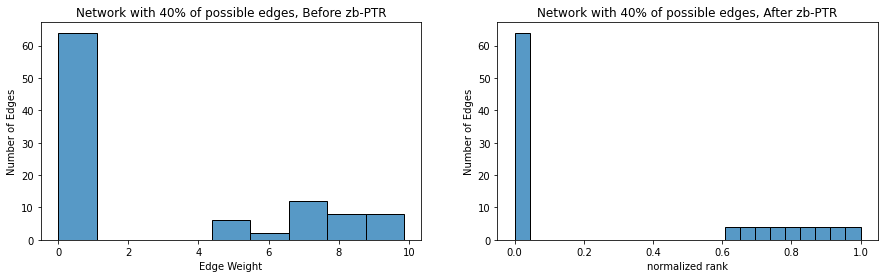

In [242]:
fig, axs = plt.subplots(1,2, figsize=(15, 4))
ax = histplot(A.flatten(), ax=axs[0], bins=9)
ax.set_xlabel("Edge Weight");
ax.set_ylabel("Number of Edges");
ax.set_title("Network with 40% of possible edges, Before zb-PTR");
ax = histplot(RAzb.flatten(), ax=axs[1], binrange=[0, 1], bins=23)
ax.set_xlabel("normalized rank");
ax.set_ylabel("Number of Edges");
ax.set_title("Network with 40% of possible edges, After zb-PTR");

#### Logging reduces magnitudinal differences between edges

###### 

In [228]:
import numpy as np

np.min(RAzb[RAzb > 0])

0.6222222222222222